# Electricity Price Forecasting

## Overview

Data exploration, visualization and implementation of a forecasting model for elecricity price given the hisorical price and the load data and wind generation data.

Data used is from the NordPool market, which is freely available from their website NordPoolgroup.com

## Data Exploration

The data will be downloaded, saved locally and then scaled appropriately, before being uploaded to S3

In [1]:
import sys
sys.executable

'/home/ec2-user/anaconda3/envs/python3/bin/python'

In [2]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler
import matplotlib.pyplot as plt
import io
import os
import time
import json


# Session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DeepAR_EPF'

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [4]:
path = 'NordPool_data/'
dataset = 'NP'
# Want our test dataset to be the last 2 years of the total dataset, which is 6 years
years_test = 2 
df_train, df_test = read_data(path=path, dataset=dataset, years_test=years_test)
df_train.head()

,Price,Exogenous 1,Exogenous 2
Date,,,
2013-01-01 00:00:00,31.05,42497.0,2798.0
2013-01-01 01:00:00,30.47,41463.0,2417.0
2013-01-01 02:00:00,28.92,40812.0,2036.0
2013-01-01 03:00:00,27.88,40246.0,1706.0
2013-01-01 04:00:00,26.96,40088.0,1427.0


Text(0.5, 0.98, 'Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

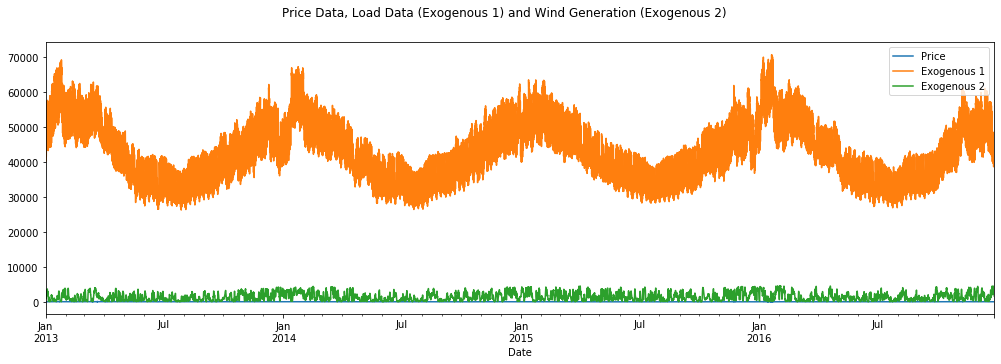

In [19]:
original_data = pd.read_csv('NordPool_data/NP.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ax = fig.add_subplot(111)
df_train.plot(figsize=(17, 5))
plt.suptitle('Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

As seen from the above plot, the values for the day-ahead load forecast and the day-ahead wind generation forecast are so much greater than the day-ahead price, that the price data is barely visible on the plot.

This indicates the data needs to be scaled prior to training or testing.

Text(0.5, 0.98, 'Day-ahead Price Data, Jan 2013 - Dec 2016')

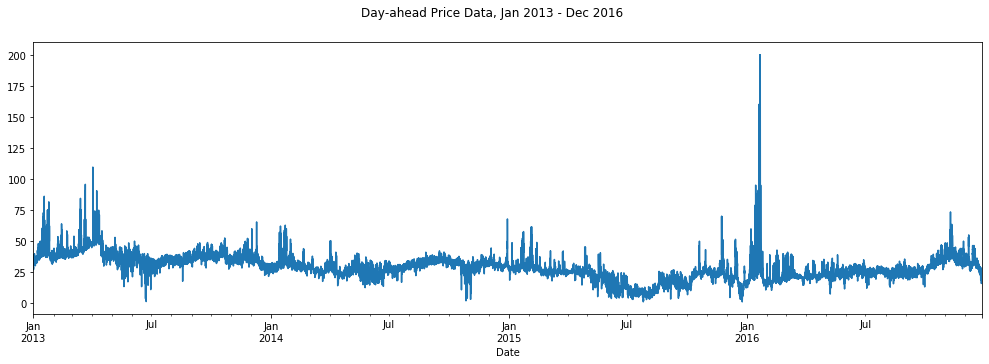

In [20]:
df_train.Price.plot(figsize=(17, 5))
plt.suptitle('Day-ahead Price Data, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Load Forecast, Jan 2013 - Dec 2016')

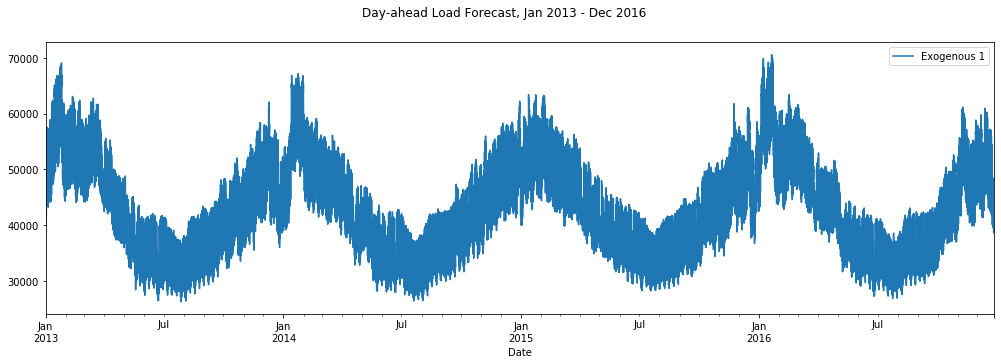

In [21]:
#df_train.Price.plot(figsize=(17, 5))
df_train.plot(y='Exogenous 1', figsize=(17, 5))
plt.suptitle('Day-ahead Load Forecast, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

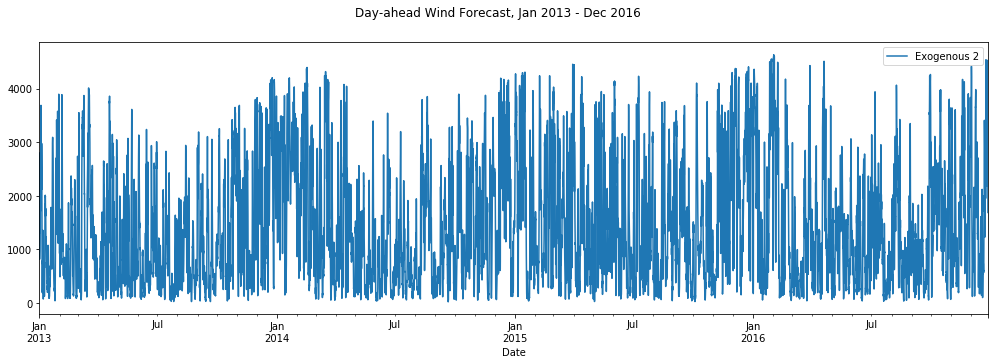

In [22]:
df_train.plot(y='Exogenous 2', figsize=(17, 5))
plt.suptitle('Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

Convert the data from the CSV to pd.Series

In [5]:
data_ts = []
path_to_data = 'NordPool_data/NP.csv'
data_from_csv = pd.read_csv(filepath_or_buffer = path_to_data, 
                        sep=',', 
                        parse_dates=True, 
                        header='infer', 
                        index_col=0,
                        infer_datetime_format=False,
                         usecols=[0,1],
                         squeeze=True)

for l in range(len(data_from_csv)):
    data_ts.append(pd.Series(data_from_csv))

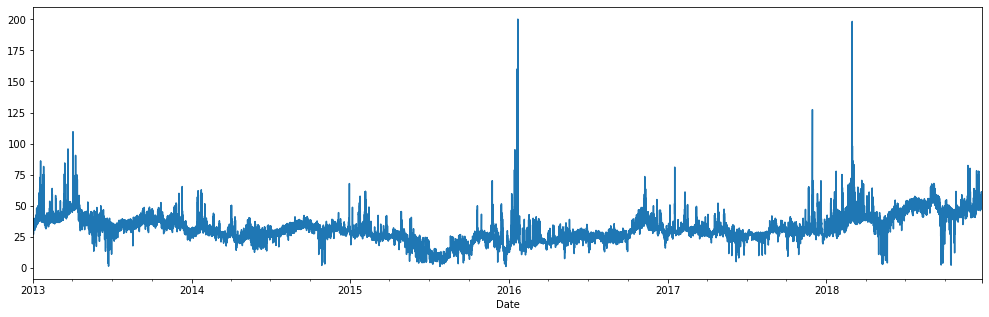

In [6]:
data_ts[0].plot(figsize=(17, 5))
plt.show()

In [7]:
freq = "H" # Data is in hourly increments
prediction_length = 24       # Want to predict the price for the next 24 hours
context_length = 72          # Will start with context length of 3 days
# First data entry point = 2013-01-01 00:00:00

t0 = "2013-01-01 00:00:00"

Split the data into training and testing data

In [8]:
data_ts_training = []
for ts in data_ts:
    data_ts_training.append(ts[:-prediction_length])

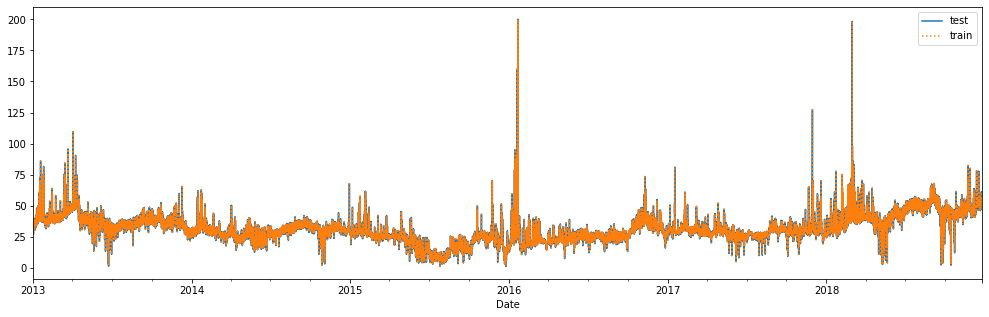

In [9]:
data_ts[0].plot(label="test")
data_ts_training[0].plot(label="train", ls=":", figsize=(17, 5))
plt.legend()
plt.show()

DeepAR requires the pandas.Series data to be converted in to JSON strings.

In [ ]:
import helper_functions

encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"
with open(FILE_TRAIN, "wb") as f:
    for ts in data_ts_training:
        f.write(helper_functions.series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in data_ts:
        f.write(helper_functions.series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

In [11]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

sagemaker/DeepAR_EPF/data/test/train.json
sagemaker/DeepAR_EPF/data/train/train.json
